The aim of this project is to take the data in https://www.kaggle.com/sl6149/data-scientist-job-market-in-the-us?select=fulltimeCHI.csv about data scientist hire in 2018 in the US and "kind-of" replicate the analysis from the uploader published in https://nycdatascience.com/blog/student-works/who-gets-hired-an-outlook-of-the-u-s-data-scientist-job-market-in-2018/

Lert's start by loading the necessary packages for R

In [38]:
library(tidyverse)
library(data.table)
library(tm)
library(slam)
library(stringr)
library(NMF)
library(gplots)


Attaching package: ‘gplots’

The following object is masked from ‘package:stats’:

    lowess



As second step, let's import the data using fread, and then let's check a bit the structure of the data.

In [2]:
job_descriptions <- fread('alldata.csv')
str(job_descriptions)

Classes ‘data.table’ and 'data.frame':	6964 obs. of  5 variables:
 $ position   : chr  "Development Director" "An Ostentatiously-Excitable Principal Research Assistant to Chief Scientist" "Data Scientist" "Data Analyst" ...
 $ company    : chr  "ALS TDI" "The Hexagon Lavish" "Xpert Staffing" "Operation HOPE" ...
 $ description: chr  "Development Director\nALS Therapy Development Institute has an immediate opening for Development Directors. Rep"| __truncated__ "Job Description\n\n\"\"The road that leads to accomplishment is narrow.\"\" -Desmond\nOstentatious is a strong "| __truncated__ "Growing company located in the Atlanta, GA area is currently looking to add a Data Scientist to their team. The"| __truncated__ "DEPARTMENT: Program OperationsPOSITION LOCATIONS: Atlanta, GA.ACCOUNTABILITY:  President of Program OperationsF"| __truncated__ ...
 $ reviews    : int  NA NA NA 44 550 385 385 899 3343 4494 ...
 $ location   : chr  "Atlanta, GA 30301 " "Atlanta, GA" "Atlanta, GA" "Atlanta, GA

This crude inspection reveals one feature that it's for me easier to manage: <br>
1. the same city appears with different names because postal codes are sometimes included <br>
2. States appear within the location and not as a separate column. <br>

To solve this issue, I first split the string a few times to isolate City and State information, and throw away postal codes.

In [3]:
job_descriptions <- job_descriptions %>%
    separate(location, c('city', 'state'), ', ', fill = "left") %>%
    separate(state, c('state'), ' ', extra = 'drop') #%>%
    #mutate(city = as.factor(city), state = as.factor(state))

str(job_descriptions)

Classes ‘data.table’ and 'data.frame':	6964 obs. of  6 variables:
 $ position   : chr  "Development Director" "An Ostentatiously-Excitable Principal Research Assistant to Chief Scientist" "Data Scientist" "Data Analyst" ...
 $ company    : chr  "ALS TDI" "The Hexagon Lavish" "Xpert Staffing" "Operation HOPE" ...
 $ description: chr  "Development Director\nALS Therapy Development Institute has an immediate opening for Development Directors. Rep"| __truncated__ "Job Description\n\n\"\"The road that leads to accomplishment is narrow.\"\" -Desmond\nOstentatious is a strong "| __truncated__ "Growing company located in the Atlanta, GA area is currently looking to add a Data Scientist to their team. The"| __truncated__ "DEPARTMENT: Program OperationsPOSITION LOCATIONS: Atlanta, GA.ACCOUNTABILITY:  President of Program OperationsF"| __truncated__ ...
 $ reviews    : int  NA NA NA 44 550 385 385 899 3343 4494 ...
 $ city       : chr  "Atlanta" "Atlanta" "Atlanta" "Atlanta" ...
 $ state      : c

A second feature that is immediately clear from the structure of the dataframe with explicit locations is that the job titles are pretty heterogeneous. To get a better sense of what it's in there, I will attempt use the tm package to count the frequency of ngrams made by 2 words. Such choice is justified because common positions for data-related jobs are combination of two words (e.g. "data science", "data engineer", "data analyst", "machine learning") 

<<TermDocumentMatrix (terms: 44, documents: 6964)>>
Non-/sparse entries: 5470/300946
Sparsity           : 98%
Maximal term length: 24
Weighting          : term frequency (tf)

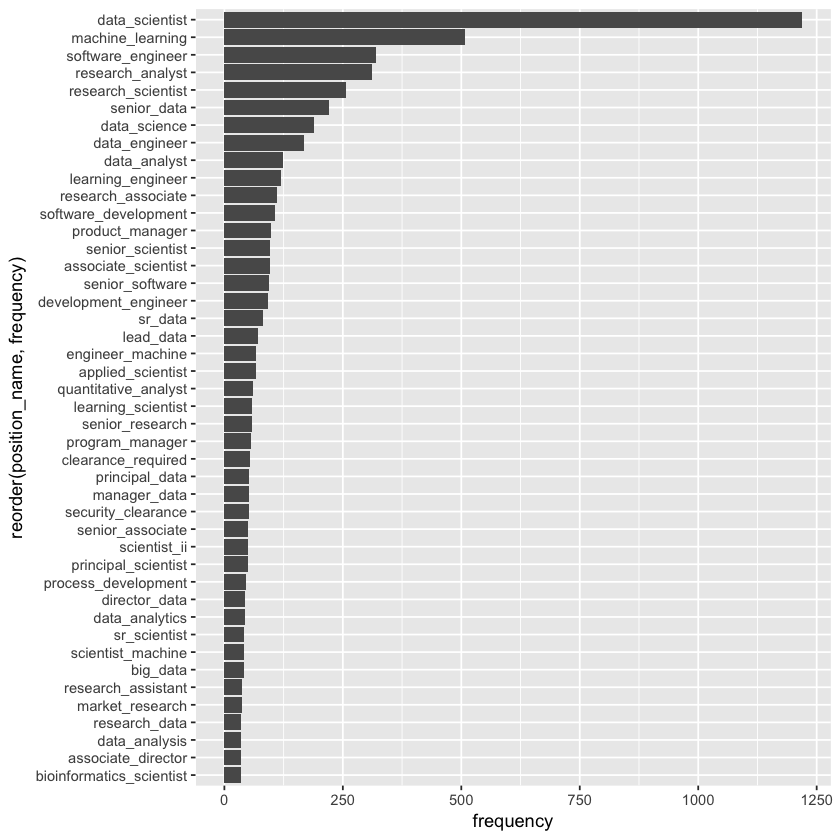

In [4]:
# preprocess job position column to remove numbers, punctuation, capital letters and stopwords
job_descriptions <- job_descriptions %>%
    mutate(position = tolower(position)) %>%
    mutate(position = removeNumbers(position)) %>%
    mutate(position = removePunctuation(position)) %>% 
    mutate(position = removeWords(position, stopwords("english")))

# create corpus from the position descriptions 
corpus_positions <- VCorpus(VectorSource(job_descriptions$position))

# create function that computes ngrams of 2 words
NLP_tokenizer <- function(x) {
  unlist(lapply(ngrams(words(x), 2), paste, collapse = "_"), use.names = FALSE)
}

# create term-document-matrix for positions and create dataframe with frequencies of bigrams
TDM_positions <- TermDocumentMatrix(corpus_positions, control = list(tokenize = NLP_tokenizer))
TDM_positions <- removeSparseTerms(TDM_positions, 0.995)
TDM_positions                          
                                    
# estracting aggregate information
frequency_of_position_names <- data.frame(frequency = row_sums(as.matrix(TDM_positions)))
frequency_of_position_names <- rownames_to_column(frequency_of_position_names, "position_name") %>%
    arrange(desc(frequency))

frequency_of_position_names %>%
    ggplot(aes(x = reorder(position_name, frequency), y = frequency)) +
    geom_col() + 
    coord_flip()

This crude analysis of bigram frequencies allows me to identify the bigrams associated to the  positions that interests me most (and possible common name variants):
1. "data science", " data scientis"
2. "software engineer", "software development", "development engineer"
3. "data engineer"
4. "data analyst", "quantitative analyst", "data analytics", "data analysis".
5. "machine learning engineer", "machine learning scientist", "engineer machine learning" (These trigrams have been inferred from bigrams that relate to them)


This allows me to give an approximate label to the job titles according to these braod categories. For the moment I will keep it simple and do that by matching strings with identifiers.

In [5]:
# define indentifiers
data_science_identifiers <- "\\bdata science\\b|\\bdata scientist\\b"
software_engineer_identifiers <- "\\bsoftware engineer\\b|\\bsoftware development\\b|\\bdevelopment engineer\\b"
data_engineer_identifiers <- "\\bdata engineer\\b"
data_analyst_identifiers <- "\\bdata analyst\\b|\\bquantitative analyst\\b|\\bdata analytics\\b|\\bdata analysis\\b"
machine_learning_engineer_identifiers <- "\\bmachine learning engineer\\b|\\bmachine learning scientist\\b|\\bengineer machine learning\\b"

# build list containing job labels with the associated identifiers
labels = c("data_science", "software_engineer", "data_engineer", "data_analyst", "machine_learning_engineer")
identifiers <- c(data_science_identifiers, software_engineer_identifiers, data_engineer_identifiers, data_analyst_identifiers, machine_learning_engineer_identifiers)
labeling_via_identifiers <- list(labels, identifiers)

# define function that combines together identifiers from different job labels
exclude_identifier <- function(labeling_conditions = labeling_via_identifiers, index_to_exclude = NULL){
    if(is.null(index_to_exclude))
        to_exclude <- paste(labeling_conditions[[2]][], collapse = "|")
    else
        to_exclude <- paste(labeling_conditions[[2]][-index_to_exclude], collapse = "|")
    return(to_exclude)
}

# define function that identify strings with at least one label from the ideintifiers
# of one job type and no identifiers from the other job types
find_position_with_unique_identifier_class <- function(position, index_of_interest, labeling_conditions = labeling_via_identifiers){
    possesses_desired_identifiers <- str_detect(job_descriptions$position, labeling_conditions[[2]][index_of_interest])
    possesses_undesired_identifiers <- str_detect(job_descriptions$position, exclude_identifier(labeling_conditions = labeling_via_identifiers, index_of_interest))
    return(possesses_desired_identifiers & (!possesses_undesired_identifiers))
}


# assign label to job_descriptions depending on the identifier found in the position column
job_descriptions <- job_descriptions %>%
    mutate(position_label_from_bigrams = case_when(
        find_position_with_unique_identifier_class(position, 1) == TRUE ~ "data_scientist",
        find_position_with_unique_identifier_class(position, 2) == TRUE ~ "software_engineer",
        find_position_with_unique_identifier_class(position, 3) == TRUE ~ "data_engineer",
        find_position_with_unique_identifier_class(position, 4) == TRUE ~ "data_analyst",
        find_position_with_unique_identifier_class(position, 5) == TRUE ~ "machine_learning_engineer",
        str_detect(position, exclude_identifier()) == FALSE ~ "other",
        TRUE ~ "mixed"
    ))

Now the final step to conder the data preparetion concluded is to prepare the description field for further NLP analysis. I will not attempt to identify ngrams or label the job description for the moment because I want to perform a non-negative matrix factorization to extract common feature of the job description and see if those matches with the job positions

In [6]:
job_descriptions <- job_descriptions %>%
    mutate(description = tolower(description)) %>%
    mutate(description = removePunctuation(description)) %>% 
    mutate(description = removeNumbers(description)) %>%
    mutate(description = removeWords(description, stopwords("english"))) %>%
    mutate(description = stemDocument(description, language = "english"))

Now that the data are ready, we can start with some preliminary analysis. The first thing I want to inspect is job demands in various states which does not correspond to tha classification "other". This should give an indicative information where one type of job is most desired.

The information I want to gather is the following
1. Where are the majority of jobs located? California with New York lagging behind.
2. Which job position is most desired in every state? Nationwide, Data science leads as the most requested job. Second place goes to software engineer.
3. Is the predominance of data science openings also a local phenomenon? Almost. The only exceptions are Washington and Colorado where data science is only the second most common job position name. This allows to state that having an abundance of data science positions in every state is a common trend, but with some notable exceptions.

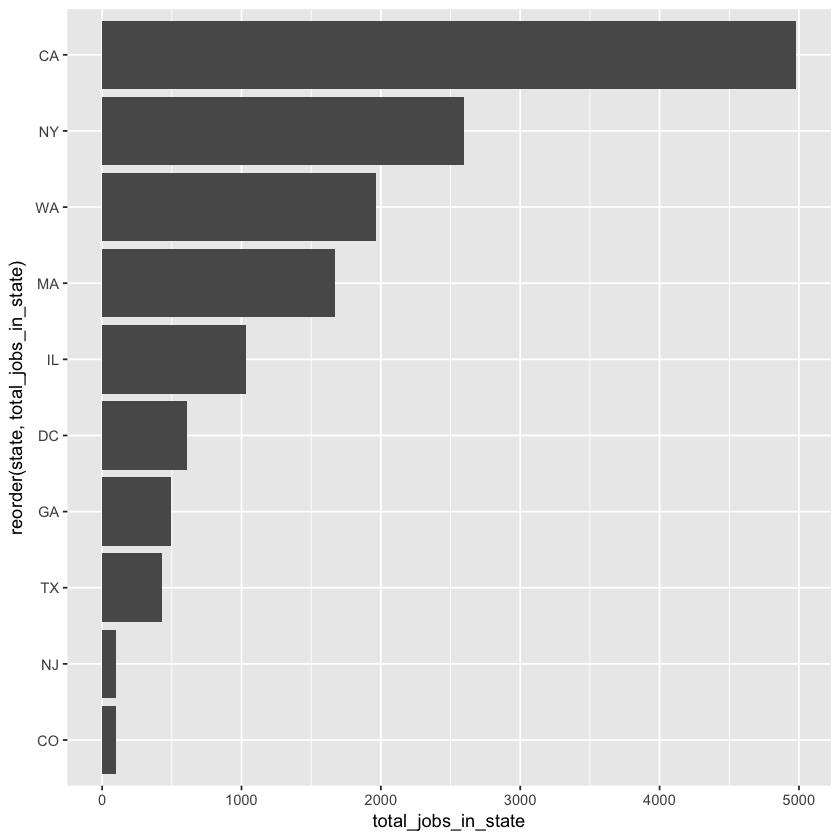

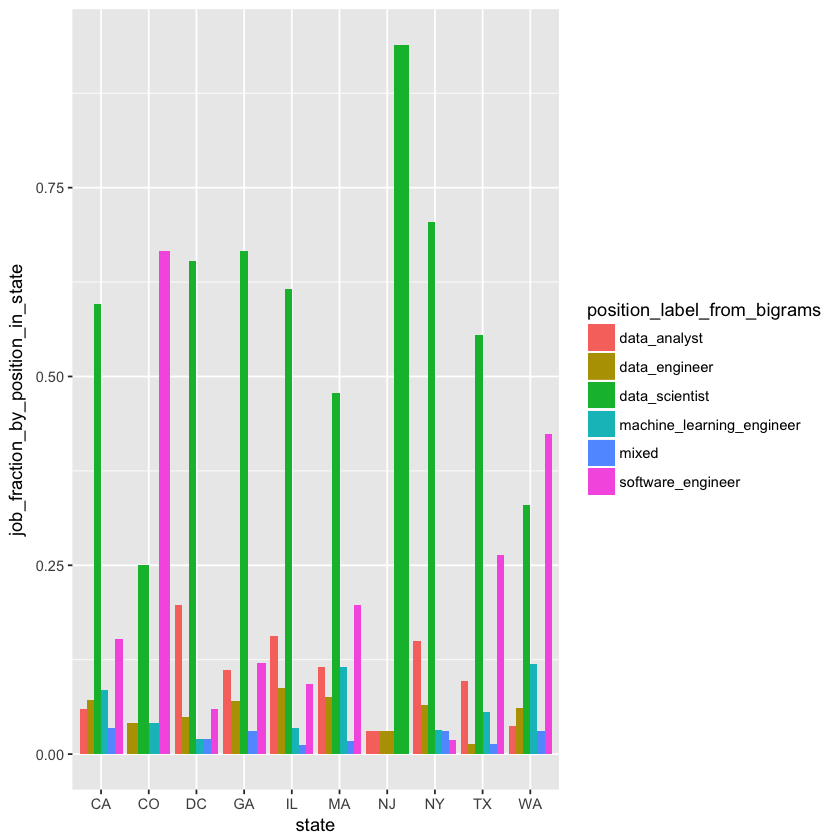

In [7]:
job_descriptions_without_others <- job_descriptions %>%
    filter(position_label_from_bigrams != "other")

job_descriptions_summary <- job_descriptions_without_others %>%
    group_by(state, position_label_from_bigrams) %>%
    summarize(jobs_by_position_in_state = n()) %>%
    mutate(total_jobs_in_state = sum(jobs_by_position_in_state)) %>%
    mutate(job_fraction_by_position_in_state = jobs_by_position_in_state / total_jobs_in_state)

where_jobs <- job_descriptions_summary %>%
    ggplot(aes(x = reorder(state, total_jobs_in_state), y = total_jobs_in_state)) +
    geom_col() +
    coord_flip()                                          
                           
which_jobs_by_state <- job_descriptions_summary %>%
    ggplot(aes(x = state, fill = position_label_from_bigrams, y = job_fraction_by_position_in_state)) + 
    geom_col(position = "dodge")
                           
                           
print(where_jobs)
print(which_jobs_by_state)
                                      


At this point, I now want to use non-negative matrix factorization to see if the job labels I have associated to the job titles corresponds to some archetypical job description. This should give an idea if the job market has an unified idea on given jobs labels.

Note that this approach tend to be computationally expensive. To keep this project at the exercise level I will reduce my dataframe to something a little bit more manageable. Furthermore, positions labeled from bigrams as data scientists dominate the dataset (see summary below), so a stratified sampling seems to provide a better dataset where to perform linguistic patterns from non-negative matrix factorization. The label with the smallest number of job descriptions will determine the sample dimension.

In [126]:
# Check that data scientist positions seems to exceed other positions
jobs_per_label <- job_descriptions_summary %>%
    ungroup() %>%
    group_by(position_label_from_bigrams) %>%
    summarize(total_jobs = sum(jobs_by_position_in_state))

# seeding for reproducibility
set.seed(1)

# undersample
sample_number_per_strata = min(jobs_per_label$total_jobs)
undersampled_job_descriptions_without_others <- job_descriptions_without_others %>%
    group_by(position_label_from_bigrams) %>%
    sample_n(sample_number_per_strata, replace = FALSE) %>%
    ungroup()

It's now time to perform the non negative matrix factorization of this undersampled dataset. To this end, I have first to produce a Term Document Matrix from the job description. This analysis require more consideration on what kind of n-grams to use for the matrix construction. 1-grams are necessary because programming languages and program suits tend to have one-word names. 2-grams covers the few program suites like power bi that have two-word names. In addition, they allow to distinguish explicit etiquettes like "data science" and "data engineer" or more critical aspects like "team player". 3-grams may capture some extra nuances such as "degree program equivalent", but often results in less intriguing information like "eighteen years age". The problem is that 2-grams and 3-grams expands the word tekens quite a lot, so I will stick with 1-grams and 2-grams for the moment

In [127]:
# create corpus from the position descriptions 
corpus_job_descriptions <- VCorpus(VectorSource(undersampled_job_descriptions_without_others$description))

# overweite NLP_tokenizer to consider of n = 1 words
NLP_tokenizer <- function(x) {
  unlist(lapply(ngrams(words(x), 1:2), paste, collapse = "_"), use.names = FALSE)
}

In [128]:
# create term-document-matrix for job descriptions
TDM_job_descriptions <- TermDocumentMatrix(corpus_job_descriptions, control = list(tokenize = NLP_tokenizer))
TDM_job_descriptions <- removeSparseTerms(TDM_job_descriptions, 0.95)         

# remove some words that do not bring anything to the analysis (this step comes because I have already performed nonegative factorization on this dataset, and it helps to make clarity)
list_of_confusing_words <- c("will", "use", "need")
#as.matrix(TDM_job_descriptions)["will", ]
TDM_job_descriptions <- TDM_job_descriptions[!(rownames(TDM_job_descriptions) %in% list_of_confusing_words), ]
TDM_job_descriptions

<<TermDocumentMatrix (terms: 1157, documents: 390)>>
Non-/sparse entries: 71858/379372
Sparsity           : 84%
Maximal term length: 24
Weighting          : term frequency (tf)

Compute nonnegative matrix factorization of the term document matrix for the job descriptions, and then inspect the basis to identify fundamental patterns. I will use 10 fundamental topics as it should allow to describe enough different topics to spot differences between the job descriptions.

In [129]:
decompostion_rank <- 10
nmf_decomposition_job_descriptions <- nmf(as.matrix(TDM_job_descriptions), decompostion_rank, seed = 0)

In [130]:
fundamental_patterns <- data.frame(basis(nmf_decomposition_job_descriptions))
fundamental_patterns <- rownames_to_column(fundamental_patterns, "word")

Now, let's have a look at the fundamental patterns to see if they can be used to identify a topic.

In [131]:
for(i in 1:10){
    pattern_to_inspect = paste("X", as.character(i), sep = "")
    temp <- fundamental_patterns %>%
        arrange(desc(.[[pattern_to_inspect]])) %>%
        head(30) %>%
        # filter(.[[pattern_to_inspect]] > 0.1)  %>%
        select(word)    
    
    print(paste("investigate pattern", pattern_to_inspect))
    print(t(temp))
}

[1] "investigate pattern X1"
     1      2        3        4      5         6         7        8     
word "data" "analyt" "experi" "busi" "statist" "analysi" "scienc" "work"
     9       10          11        12               13            14     
word "model" "scientist" "insight" "data_scientist" "data_scienc" "skill"
     15       16     17    18         19    20       21          
word "custom" "role" "sql" "communic" "set" "advanc" "understand"
     22             23        24     25       26     27     28         29      
word "data_analysi" "product" "tool" "analyz" "year" "larg" "data_set" "report"
     30       
word "present"
[1] "investigate pattern X2"
     1       2        3              4        5       6      7          
word "learn" "machin" "machin_learn" "experi" "model" "data" "algorithm"
     8        9        10        11     12         13      14        15       
word "scienc" "comput" "problem" "deep" "research" "appli" "develop" "languag"
     16       17     1

Now, a quick analysis shows that
1. pattern X1 describes a data analyst or data science position
2. pattern X2 describes a machine learning engineer position or a data science position 
3. pattern X3 describes a data engineer position
4. pattern X4 describes a software engineer position
5. pattern X5 is a mixture of terms that does not highlight a specific theme.
6. pattern X6 has a data science flavor, but it's mostly worlds describing teamwork and the company desired impact 
7. pattern X7 describes gender/race equal opportunities
8. pattern X8 describes fintech-related jobs. It does have some data analyst flavor, but it's not quite clear
9. pattern X9 describes both interpersonal skills and healthcare benefits
10. pattern X10 contains a mixture of words that mixes various themes already mentioned. I believe it's the pattern describing the common structure of IT job descriptions.

Using these identifications, I can relabel the patterns for what they are


In [143]:
renaming_convention <- c("word", 
                         "data_science",
                         "machine_learning_engineer",
                         "data_engineer",
                         "software_engineer",
                         "mixed_nonspecific_words_1",
                         "teamwork",
                         "equal_opportunities",
                         "fintech",
                         "soft_skills",
                         "mixed_nonspecific_words_2")

colnames(fundamental_patterns) = renaming_convention;
coefficients_for_fundamental_patterns <- data.frame(t(coef(nmf_decomposition_job_descriptions)))

colnames(coefficients_for_fundamental_patterns) = renaming_convention[2:11];

To better understand which patterns deserves more attention, let's find out which patterns have the most important contributions in the dataset. To this end, I will first throw away few patterns that have no value to identify the type of a job description. I will also drop the pattern describing fintech positions as it seems a less relevant descriptor than others

In [144]:
non_descriptive_patterns <- c("mixed_nonspecific_words_1", "teamwork", "equal_opportunities", "fintech", "soft_skills", "mixed_nonspecific_words_2")
coefficients_for_fundamental_job_descriptive_patterns <- coefficients_for_fundamental_patterns %>%
    select(- one_of(non_descriptive_patterns))

Having thrown away columns that I found not of interest, I can now assign a second label to jobs based on the dominant contribution from the non-negative matrix factorization patterns

In [145]:
dominant_descriptive_pattern_in_job_description <- colnames(coefficients_for_fundamental_job_descriptive_patterns)[max.col(coefficients_for_fundamental_job_descriptive_patterns)]

undersampled_job_descriptions_without_others <- undersampled_job_descriptions_without_others %>%
    mutate(dominant_pattern_identity = dominant_descriptive_pattern_in_job_description)

At this point, we have a way to compare if jobs labels according to bigrams in the job title matches with the dominant pattern in the job description from the non-negative matrix factorization. This allows to understand if there is a consensus between how a job is titled and what the company is really looking. To investigate that I use a contingency table. To better assess how serious the missmathc is I also show a table showing the fraction of job descriptions with a dominant pattern for each label given by the bigrams found in the job title.

In [153]:
contingency_table_labels <- undersampled_job_descriptions_without_others %>%
    select(dominant_pattern_identity, position_label_from_bigrams,) %>%
    table()
contingency_table_labels

frequency_of_dominant_patterns_consistent_with_bigrams = sweep(contingency_table_labels, 1, rowSums(contingency_table_labels), "/")
t(frequency_of_dominant_patterns_consistent_with_bigrams)

frequency_of_dominant_patterns_consistent_with_bigrams = sweep(contingency_table_labels, 2, colSums(contingency_table_labels), "/")
frequency_of_dominant_patterns_consistent_with_bigrams

                           position_label_from_bigrams
dominant_pattern_identity   data_analyst data_engineer data_scientist
  data_engineer                        7            58              3
  data_science                        44             0             45
  machine_learning_engineer            9             1             15
  software_engineer                    5             6              2
                           position_label_from_bigrams
dominant_pattern_identity   machine_learning_engineer mixed software_engineer
  data_engineer                                     8    13                 9
  data_science                                      3    12                 3
  machine_learning_engineer                        47    29                11
  software_engineer                                 7    11                42

                           dominant_pattern_identity
position_label_from_bigrams data_engineer data_science
  data_analyst                0.071428571  0.411214953
  data_engineer               0.591836735  0.000000000
  data_scientist              0.030612245  0.420560748
  machine_learning_engineer   0.081632653  0.028037383
  mixed                       0.132653061  0.112149533
  software_engineer           0.091836735  0.028037383
                           dominant_pattern_identity
position_label_from_bigrams machine_learning_engineer software_engineer
  data_analyst                            0.080357143       0.068493151
  data_engineer                           0.008928571       0.082191781
  data_scientist                          0.133928571       0.027397260
  machine_learning_engineer               0.419642857       0.095890411
  mixed                                   0.258928571       0.150684932
  software_engineer                       0.098214286       0.575342466

                           position_label_from_bigrams
dominant_pattern_identity   data_analyst data_engineer data_scientist
  data_engineer               0.10769231    0.89230769     0.04615385
  data_science                0.67692308    0.00000000     0.69230769
  machine_learning_engineer   0.13846154    0.01538462     0.23076923
  software_engineer           0.07692308    0.09230769     0.03076923
                           position_label_from_bigrams
dominant_pattern_identity   machine_learning_engineer      mixed
  data_engineer                            0.12307692 0.20000000
  data_science                             0.04615385 0.18461538
  machine_learning_engineer                0.72307692 0.44615385
  software_engineer                        0.10769231 0.16923077
                           position_label_from_bigrams
dominant_pattern_identity   software_engineer
  data_engineer                    0.13846154
  data_science                     0.04615385
  machine_learning_eng

These two tables indicates a few interesting insights.

On the company side, the table suggest that companies often fail to name the job opening according to their true need. More specifically,
1. Companies who needs a person with data engineer skills correctly label the job opening only 3 times out of 5. The biggest confounder are data engineer positions which are mislabeled as a mixture of other job titles or as software engineer jobs.
2. Companies that needs people with a data science background label those positions as either as data scientist (40% of the times) or data analyst (40% of the time). This may reflect the inertia in dropping the data analyst job title as obsolete.
3. Companies that needs people with a machine learning engneer background opens the positions with the correct job title less than half of the times. 25% of the time those companies includes multiple job titles, whereas they erroneously label thos positions as data scientist and software engineer about 10% of the times each. This may indicate that companies do not clearly understand how to get the attention of machine learning specialists when they need them.
4. Companies that need software engineer open positions with that title 3 times out of 5 but they can mislabel them as data engineer, machine learning engineer positions or add extra labels to the job descriptions. This is quite odd because software engineers have been around for quite a long time and their job tasks should be well understood.

On the applicant side the table elucidates that people will often apply for the wrong position. More specifically:
1. People that apply to positions with data science analyst title are applying for the wrong positions 30% of the times. In particular, they might be applying for a machine learning engineer positions (10% of the times) or a data engineer position (10% of the times) instead.
2. People that apply to positions with data engineer titles are indeed applying to data engineer positions. The only confounder is that they might be applying to a software engineer position, but this happen only 10% of the times.
3. People that apply to position with data science title are applyting to the wrong positions 30% of the times. However, in the majority of these cases people are truly applyionf to a machine learning engineer position. This might not be particularly serious given the similarities between the two jobs.
4. People that apply to positions with the machine learning engineer title are applying to a different position 30% of the times. In those cases, peopel are instead applying for data engineer of software engineer positions.
5. People that apply to positions with software engineer title may be applying for the wrong position 35% of the times. When this happen, they might be applying for data engineer or machine learning engineer positions instead
